In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
from pycbc.filter import match, overlap_cplx
from pycbc.psd import aLIGOZeroDetHighPower
from simple_pe.waveforms import generate_eccentric_waveform, calculate_eccentric_harmonics
from calcwf import get_h

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [44]:
M = 60
q = 2
e = 0.01

harms = calculate_eccentric_harmonics(M, q, e, 0, 0, 15, 4096, tlen=32, f_ref_e=10, n_ecc_harms=4)

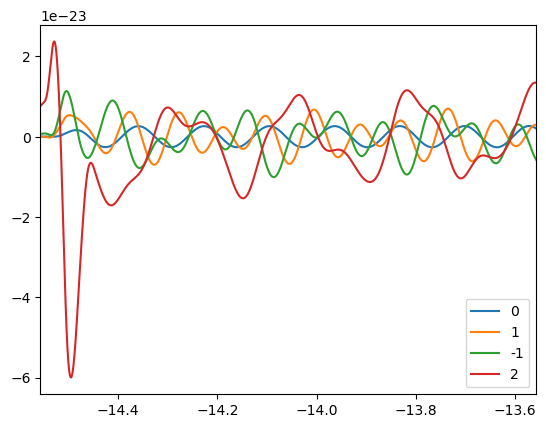

In [45]:
for key in harms.keys():
    wf = harms[key].to_timeseries()
    plt.plot(wf.sample_times, wf, label=str(key))
plt.legend()
plt.xlim(wf.sample_times[0], wf.sample_times[0]+1)
plt.show()

In [40]:
delta_f = 1.0 / harms[0].duration
flen = len(harms[0])
psd = aLIGOZeroDetHighPower(flen, delta_f, 30)

np.abs(overlap_cplx(harms[2], harms[-1], psd=psd, low_frequency_cutoff=30))

0.05543159233386201

Try to write more accurate shifted_e equation:

In [56]:
# Using 3PN ecc evolution from eqs 11, 12 of https://arxiv.org/pdf/2504.12469
def g_of_e(f, M, q):

    eta = q/(1+q)**2
    xi = M*aconst.M_sun.value*np.pi*f

    pf_2 = (-2833/2016+(197/72)*eta)
    pf_3 = (-377/144)*np.pi
    pf_4 = (77006005/24385536-(1143767/145152)*eta+(43807/10368)*eta**2)
    pf_5 = (9901567/1451520-(202589/362880)*eta)*np.pi
    pf_6_1 = (-33320661414619/386266890240+(3317/252)*np.euler_gamma+(180721/41472)*np.pi**2)
    pf_6_2 = ((161339510737/8778792960+(3977/2304)*np.pi**2)*eta-(359037739/20901888)*eta**2)
    pf_6_3 = ((10647791/2239488)*eta**3-(87419/3780)*np.log(2)+(26001/1120)*np.log(3)+(3317/504)*np.log(16*xi**(2/3)))
    pf_6 = pf_6_1+pf_6_2+pf_6_3

    g = 1 + pf_2*xi**(2/3) + pf_3*xi + pf_4*xi**(4/3) + pf_5*xi**(5/3) + pf_6*xi**2

    return g

def shifted_e_3pn(s_f, f, e, M, q):

    s_e = e*(f/s_f)**(19/18)*(g_of_e(s_f, M, q)/g_of_e(f, M, q))
    return s_e

In [57]:
shifted_e_3pn(11, 10, 0.2, 60, 1)

0.21910804364291353

Eccentricity has increased with increased frequency, so this has clearly not worked.